# Hands on tutorial of Graph Representation Learning

In this lecture, we will go through the following topics
1. Graph structued data in Python
2. GNN package - Pytorch-Geometric introduction
3. Representation in Graphs - node2vec, GCN
4. GNN with downstrean tasks
5. GNN for text classification


In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html

import torch_cluster
import os.path as osp
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

1.12.1+cu113
     |████████████████████████████████| 7.9 MB 21.2 MB/s 
     |████████████████████████████████| 3.5 MB 33.3 MB/s 
     |████████████████████████████████| 2.4 MB 23.1 MB/s 


## Obtaining node embedding with Graph Neural Network
For a GNN layer, Message Passing is defined as the process of taking node features of the neighbours, transforming them, and "passing" them to the source node. This process is repeated, in parallel, for all nodes in the graph. In that way, all neighbourhoods are examined by the end of this step.

### Node2vec v.s. GNN
Previously, we learned how to obtain node embedding with Node2vec. However, Node2vec uses the embedding layer as the node feature **without considering the node feature**. GNN, on the contrary, adopts a different way to learn node embedding via the so-called **Message Passing** function or **Neighbor Aggregation** operation which obtains embedding by aggregating information from neighboring nodes.

### A simple GNN
Let first build a bisic GNN to demonstrate the message passing of GNN.
The node embedding of each node is defined as follows:

\begin{equation}
z^k_i = \sum_{j\in N(i)} z^{k-1}_j
\end{equation}

![](https://i.imgur.com/77VBsTd.png)

In [2]:
from torch_geometric.nn import MessagePassing

In [3]:
class SimpleGNN(MessagePassing):
    def __init__(self,aggr="sum"):
        super().__init__(aggr=aggr)

    def forward(self, x, edge_index):
        return self.propagate(edge_index,x=x)

In [4]:
x = torch.arange(9).reshape(3,3).float()
edge_index = [[0,1],[2,1]]
edge_index = torch.tensor(edge_index).T
print(x)

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])


In [5]:
model = SimpleGNN()
model
model(x,edge_index)

tensor([[ 0.,  0.,  0.],
        [ 6.,  8., 10.],
        [ 0.,  0.,  0.]])

### Bidrectional edges

In [6]:
from torch_geometric.utils import to_undirected
edge_index = to_undirected(edge_index)
print(edge_index)

tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])


In [7]:
model = SimpleGNN()
model
model(x,edge_index)

tensor([[ 3.,  4.,  5.],
        [ 6.,  8., 10.],
        [ 3.,  4.,  5.]])

### Adding self-connection
![](https://i.imgur.com/h2x1Qq5.png)

In [8]:
x = torch.arange(9).reshape(3,3).float()
edge_index = [[0,1],[2,1]] + [[0,0],[1,1],[2,2]]
edge_index = torch.tensor(edge_index).T
print(x)

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])


In [9]:
model = SimpleGNN()
model(x,edge_index)

tensor([[ 0.,  1.,  2.],
        [ 9., 12., 15.],
        [ 6.,  7.,  8.]])

### Advance implementation of self-connection

In [10]:
# another way to implement self-connection
class SimpleGNN(MessagePassing):
    def __init__(self,aggr="sum"):
        super().__init__(aggr=aggr)

    def forward(self, x, edge_index):
        return self.propagate(edge_index,x=x) + x

In [11]:
x = torch.arange(9).reshape(3,3)
edge_index = [[0,1],[2,1]]
edge_index = torch.tensor(edge_index).T
print(x)

model = SimpleGNN()
model(x,edge_index)

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])


tensor([[ 0,  1,  2],
        [ 9, 12, 15],
        [ 6,  7,  8]])

###  More common usage: bidirectional edges with self-connection

In [12]:
# bidirectional edges with self-connection
x = torch.arange(9).reshape(3,3).float()
edge_index = [[0,1],[2,1]]
edge_index = torch.tensor(edge_index).T
edge_index = to_undirected(edge_index)
print(x)

model = SimpleGNN()
model(x,edge_index)

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])


tensor([[ 3.,  5.,  7.],
        [ 9., 12., 15.],
        [ 9., 11., 13.]])

### Differnt pooling function
There are various pooling function you can choose during the message passing stage to control how those information was aggregated. <br>
**Sum, Mean and Max Pooling** are the most common and widely used operation.

In [13]:
# another way to implement self-connection
class SimpleGNN(MessagePassing):
    def __init__(self,**kwagrs):
        super().__init__(**kwagrs)

    def forward(self, x, edge_index):
        return self.propagate(edge_index,x=x)

In [14]:
# bidirectional edges with self-connection
x = torch.arange(9).reshape(3,3).float()
edge_index = [[0,1],[2,1]] + [[0,0],[1,1],[2,2]]
edge_index = torch.tensor(edge_index).T
edge_index = to_undirected(edge_index)
print(x)

# sum pooling
model = SimpleGNN(aggr="sum")
print("Results of sum pooling...")
print(model(x,edge_index))
print("-"*30)

# mean pooling
model = SimpleGNN(aggr="mean")
print("Results of mean pooling...")
print(model(x,edge_index))
print("-"*30)

# sum pooling
model = SimpleGNN(aggr="max")
print("Results of max pooling...")
print(model(x,edge_index))
print("-"*30)

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])
Results of sum pooling...
tensor([[ 3.,  5.,  7.],
        [ 9., 12., 15.],
        [ 9., 11., 13.]])
------------------------------
Results of mean pooling...
tensor([[1.5000, 2.5000, 3.5000],
        [3.0000, 4.0000, 5.0000],
        [4.5000, 5.5000, 6.5000]])
------------------------------
Results of max pooling...
tensor([[3., 4., 5.],
        [6., 7., 8.],
        [6., 7., 8.]])
------------------------------


### The most powerful techniques of GNN: Exploring multi-hop neighbor by stacking GNN layers

In [15]:
# bidirectional edges 
x = torch.arange(9).reshape(3,3).float()
edge_index = [[0,1],[2,1]]
edge_index = torch.tensor(edge_index).T
edge_index = to_undirected(edge_index)
model = SimpleGNN(aggr="sum")

# first-hop neighbor
print("Embedding after first message passing...")
first_embedding = model(x,edge_index)
print(first_embedding)

# second-hop neighbor
print("Embedding after second message passing...")
second_embedding = model(first_embedding,edge_index)
print(second_embedding)

Embedding after first message passing...
tensor([[ 3.,  4.,  5.],
        [ 6.,  8., 10.],
        [ 3.,  4.,  5.]])
Embedding after second message passing...
tensor([[ 6.,  8., 10.],
        [ 6.,  8., 10.],
        [ 6.,  8., 10.]])


In [16]:
# bidirectional edges with self-connection
x = torch.arange(9).reshape(3,3).float()
edge_index = [[0,1],[2,1]] + [[0,0],[1,1],[2,2]]
edge_index = torch.tensor(edge_index).T
edge_index = to_undirected(edge_index)
model = SimpleGNN(aggr="sum")

# first-hop neighbor
print("Embedding after first message passing...")
first_embedding = model(x,edge_index)
print(first_embedding)

# second-hop neighbor
print("Embedding after second message passing...")
second_embedding = model(first_embedding,edge_index)
print(second_embedding)

Embedding after first message passing...
tensor([[ 3.,  5.,  7.],
        [ 9., 12., 15.],
        [ 9., 11., 13.]])
Embedding after second message passing...
tensor([[12., 17., 22.],
        [21., 28., 35.],
        [18., 23., 28.]])


In [17]:
# another way to implement multi-hop message passing
class SimpleGNN(MessagePassing):
    def __init__(self,n_layers=1,**kwagrs):
        super().__init__(**kwagrs)
        self.n_layers = n_layers

    def forward(self, x, edge_index):
        for _ in range(self.n_layers):
            x = self.propagate(edge_index,x=x)
        return x

In [18]:
# bidirectional edges with self-connection
x = torch.arange(9).reshape(3,3).float()
edge_index = [[0,1],[2,1]] + [[0,0],[1,1],[2,2]]
edge_index = torch.tensor(edge_index).T
edge_index = to_undirected(edge_index)

# first-hop neighbor
print("Embedding after first message passing...")
model = SimpleGNN(n_layers=1,aggr="sum")
first_embedding = model(x,edge_index)
print(first_embedding)

# second-hop neighbor
print("Embedding after second message passing...")
model = SimpleGNN(n_layers=2,aggr="sum")
second_embedding = model(x,edge_index)
print(second_embedding)

Embedding after first message passing...
tensor([[ 3.,  5.,  7.],
        [ 9., 12., 15.],
        [ 9., 11., 13.]])
Embedding after second message passing...
tensor([[12., 17., 22.],
        [21., 28., 35.],
        [18., 23., 28.]])


### Nueral Networks in GNN

In [19]:
# another way to implement multi-hop message passing
class CoolGNN(MessagePassing):
    def __init__(self,n_layers=1,**kwagrs):
        super().__init__(**kwagrs)
        self.n_layers = n_layers
        self.nn_layers = nn.ModuleList([nn.Linear(3,3) for _ in range(self.n_layers)])

    def forward(self, x, edge_index):
        for i in range(self.n_layers):
            x = self.nn_layers[i](self.propagate(edge_index,x=x))
            x = torch.relu(x)
        return x

In [20]:
# bidirectional edges with self-connection
x = torch.arange(9).reshape(3,3).float()
edge_index = [[0,1],[2,1]] + [[0,0],[1,1],[2,2]]
edge_index = torch.tensor(edge_index).T
edge_index = to_undirected(edge_index)

# first-hop neighbor
print("Embedding after first message passing...")
model = CoolGNN(n_layers=1,aggr="sum")
first_embedding = model(x,edge_index)
print(first_embedding)

# second-hop neighbor
print("Embedding after second message passing...")
model = CoolGNN(n_layers=2,aggr="sum")
second_embedding = model(x,edge_index)
print(second_embedding)

Embedding after first message passing...
tensor([[0.9419, 0.0000, 0.0000],
        [4.2793, 0.0000, 0.0000],
        [4.4482, 0.0000, 0.0000]], grad_fn=<ReluBackward0>)
Embedding after second message passing...
tensor([[ 0.0000,  0.0000,  9.0748],
        [ 0.0000,  0.0000, 14.7378],
        [ 0.0000,  0.0000, 11.7893]], grad_fn=<ReluBackward0>)


In [21]:
# using off-the-shelf GNN models
from torch_geometric.nn import GCNConv
model = GCNConv(in_channels=3,out_channels=16)
embedding = model(x,edge_index)
print(embedding)

tensor([[-0.0532,  0.4490, -0.0775, -0.0682, -0.7629,  2.0140,  2.0791,  0.6149,
          0.0938,  1.6181, -0.3021,  0.0143, -0.1603,  0.9250,  1.7917,  0.9856],
        [ 0.1408,  1.0614,  0.0523, -0.1064, -1.5177,  3.6776,  4.3417,  1.3187,
         -0.4439,  3.3190, -0.6758,  0.4626, -0.5554,  1.9994,  4.3096,  2.0288],
        [ 0.2757,  1.2278,  0.1600, -0.0999, -1.6348,  3.7959,  4.7799,  1.4683,
         -0.7950,  3.6253, -0.7655,  0.7165, -0.7172,  2.2337,  5.0167,  2.2196]],
       grad_fn=<AddBackward0>)


## Unsupervised GRL with GraphSAGE
Previously, we mentioned that Node2vec outperform MLP in semi-supervised node classification task.<br>
However, including both node feature and graph embedding did not boost the performance significantly. <br>
Here, we introduce the `GraphSAGE` that is a GNN based approach to model node feature and graph structure at the same time.

GraphSAGE stands for Graph **SA**mple and Aggre**G**at**E**. It's a model to generate node embeddings for large, very dense graphs (to be used at companies like Pinterest).

The work introduces learned aggregators on a node's neighbourhoods. Unlike traditional GATs or GCNs that consider all nodes in the neighbourhood, GraphSAGE uniformly samples the neighbours and uses the learned aggregators on them. 

Suppose we have $L$ layers in the network (depth), each layer $l \in \{1,\dots,L\}$ looks at a larger $l$-hop neighbourhood w.r.t. the source node (as one would expect). Each source node is then updated by concatenating the node embedding with the sampled messages before being passed through a MLP $F$ and non-linearity $\sigma$. 

For a certain layer $l$,

\begin{equation}
h_v^{(l)} = W_l\cdot h_v^{(l-1)} + W_r \cdot AGG(\{h_u^{(l-1)}, \forall u \in N(v) \})
\end{equation}

A simple mean aggregator could be:
\begin{equation}
AGG(\{h_u^{(l-1)}, \forall u \in N(v) \}) = \frac{1}{|N(v)|} \sum_{u\in N(v)} h_u^{(l-1)}
\end{equation}

There are supervised and unsupervised learning framework for GraphSAGE. <br>
Here we present the unsupervised learning scheme which optimize the following objective:
\begin{equation}
\log \left ( \sigma (h_u^{\top} h_v)  \right) - \sum_{i=1}^k \log \left ( \sigma (h_u^{\top} h_{n_i})  \right), n_i \sim P_V
\end{equation}
![](https://snap.stanford.edu/graphsage/sample_and_agg.png)

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = 'Cora'
path = osp.join('.', 'data', dataset)
dataset = Planetoid(root=path, name='Cora', transform=NormalizeFeatures())
data = dataset[0]

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.linear_model import LogisticRegression
from torch_cluster import random_walk

from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.nn import SAGEConv

In [50]:
class SAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers):
        super().__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        self.num_layers = num_layers
        for i in range(num_layers):
            in_channels = in_channels if i == 0 else hidden_channels
            self.convs.append(SAGEConv(in_channels, hidden_channels))

    def forward(self, x, edge_index):
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

    def full_forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

In [51]:
# define neighbor sampler
train_loader = LinkNeighborLoader(
    data,
    batch_size=256,
    shuffle=True,
    neg_sampling_ratio=1.0,
    num_neighbors=[10, 10],
)

In [52]:
data.edge_index.shape

torch.Size([2, 10556])

In [27]:
for batch in train_loader:
    print(batch)
    break

Data(x=[2374, 1433], edge_index=[2, 7765], y=[2374], train_mask=[2374], val_mask=[2374], test_mask=[2374], edge_label_index=[2, 512], edge_label=[512])


In [28]:
print("Edge label index: containing both positive and negative edges")
print(batch.edge_label_index)

print("Edge label: 1 stands for positive and 0 stands for negative node pair(edge)")
print(batch.edge_label)

Edge label index: containing both positive and negative edges
tensor([[283, 735, 626,  ..., 168, 225, 572],
        [322, 736, 717,  ..., 764, 792, 457]])
Edge label: 1 stands for positive and 0 stands for negative node pair(edge)
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [29]:
# define training and testing functions
def train():
    model.train()

    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        embedding = model(batch.x, batch.edge_index)
        embedding_src = embedding[batch.edge_label_index[0]]
        embedding_dst = embedding[batch.edge_label_index[1]]
        pred = (embedding_src * embedding_dst).sum(dim=-1)
        loss = F.binary_cross_entropy_with_logits(pred, batch.edge_label)
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * pred.size(0)

    return total_loss / data.num_nodes


@torch.no_grad()
def test():
    model.eval()
    out = model.full_forward(x, edge_index).cpu()

    clf = LogisticRegression()
    clf.fit(out[data.train_mask], data.y[data.train_mask])

    val_acc = clf.score(out[data.val_mask], data.y[data.val_mask])
    test_acc = clf.score(out[data.test_mask], data.y[data.test_mask])

    return val_acc, test_acc

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SAGE(data.num_node_features, hidden_channels=64, num_layers=2)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005,weight_decay=1e-4)
x, edge_index = data.x.to(device), data.edge_index.to(device)

In [31]:
for epoch in range(1, 101):
    loss = train()
    val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 5.2018, Val: 0.4200, Test: 0.4130
Epoch: 002, Loss: 4.5660, Val: 0.5360, Test: 0.5690
Epoch: 003, Loss: 4.2098, Val: 0.6120, Test: 0.6490
Epoch: 004, Loss: 4.1034, Val: 0.6600, Test: 0.6700
Epoch: 005, Loss: 4.0248, Val: 0.7000, Test: 0.6900
Epoch: 006, Loss: 3.9358, Val: 0.7080, Test: 0.7030
Epoch: 007, Loss: 3.8512, Val: 0.7140, Test: 0.7080
Epoch: 008, Loss: 3.8309, Val: 0.7160, Test: 0.7090
Epoch: 009, Loss: 3.7905, Val: 0.7060, Test: 0.7170
Epoch: 010, Loss: 3.7921, Val: 0.7060, Test: 0.7150
Epoch: 011, Loss: 3.7615, Val: 0.7100, Test: 0.7330
Epoch: 012, Loss: 3.7622, Val: 0.7180, Test: 0.7380
Epoch: 013, Loss: 3.7393, Val: 0.7140, Test: 0.7410
Epoch: 014, Loss: 3.7357, Val: 0.7320, Test: 0.7350
Epoch: 015, Loss: 3.6794, Val: 0.7340, Test: 0.7530
Epoch: 016, Loss: 3.7139, Val: 0.7240, Test: 0.7430
Epoch: 017, Loss: 3.6406, Val: 0.7160, Test: 0.7410
Epoch: 018, Loss: 3.6720, Val: 0.7220, Test: 0.7370
Epoch: 019, Loss: 3.6960, Val: 0.7380, Test: 0.7570
Epoch: 020, 

## Performance comparison
Recall that in the previous examples, we performed node classification in 3 different ways.
1. Bag of word + MLP with `Accuracy:0.6`
2. Node2vec + Logistic regression with `Accuracy:0.703`
3. Node2vec with Bag of word + Logistic regression with `Accuracy:0.707`
4. GraphSAGE: with Bag of word + Logistic regression with `Accuracy:0.791`

We noticed that node embedding + node feature cannot improve the performance significantly. <br>
However, we make use of node feature and graph structure at the same time and boost the accuracy up to **0.791** with a simple two-layer `GraphSAGE`.

## End-to-end semi-supervised learning with Graph Convolution Network(GCN)
Previously, we adopt a two stage classification pipeline where we first extract network feature via unsupervised learning then utilize a classifier to predict its label. <br>
The two-stage design could be suboptimal since the network features were not extracted for specific task. <br>
Hence, GCN is our best choice since GCN extract feature by aggregating information from neighboring nodes and making classification simultaneously.

In [74]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True,
                             normalize=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True,
                             normalize=True)

    def forward(self, x, edge_index, edge_weight=None):
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x

In [93]:
dim = 64
model = GCN(dataset.num_features, dim, dataset.num_classes)
model, data = model.to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5)
print(model)

GCN(
  (conv1): GCNConv(1433, 128)
  (conv2): GCNConv(128, 7)
)


## Define training/testing fucntions

### Training stage
The GCN model takes two inputs: `x` and `edge_index` which represent the **node feature** and **edge index**, respectively. <br>
Note: The training procedure is slightly different than what we used to do. <br>
Since GNN takes the whole graph as input and output embeddings of individual nodes, the concept of "batch" does not apply here. 


In [94]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_weight)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x, data.edge_index, data.edge_weight).argmax(dim=-1)
    mask = data.test_mask
    accs = (int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs

In [95]:
for epoch in range(400):
    loss = train()
    test_acc = test()
    print(f"Loss:{loss:.4f} Testing accuracy:{test_acc:.4f}")

Loss:1.9467 Testing accuracy:0.1580
Loss:1.9450 Testing accuracy:0.3110
Loss:1.9426 Testing accuracy:0.4270
Loss:1.9403 Testing accuracy:0.4770
Loss:1.9387 Testing accuracy:0.5190
Loss:1.9367 Testing accuracy:0.5510
Loss:1.9336 Testing accuracy:0.6000
Loss:1.9305 Testing accuracy:0.6270
Loss:1.9295 Testing accuracy:0.6550
Loss:1.9259 Testing accuracy:0.6810
Loss:1.9215 Testing accuracy:0.6850
Loss:1.9196 Testing accuracy:0.6960
Loss:1.9167 Testing accuracy:0.7030
Loss:1.9135 Testing accuracy:0.7050
Loss:1.9094 Testing accuracy:0.7090
Loss:1.9057 Testing accuracy:0.7070
Loss:1.9006 Testing accuracy:0.7080
Loss:1.8985 Testing accuracy:0.7070
Loss:1.8940 Testing accuracy:0.7120
Loss:1.8907 Testing accuracy:0.7140
Loss:1.8862 Testing accuracy:0.7130
Loss:1.8833 Testing accuracy:0.7150
Loss:1.8775 Testing accuracy:0.7160
Loss:1.8701 Testing accuracy:0.7180
Loss:1.8685 Testing accuracy:0.7200
Loss:1.8626 Testing accuracy:0.7210
Loss:1.8593 Testing accuracy:0.7240
Loss:1.8562 Testing accuracy

## Performance comparison
Recall that in the previous examples, we performed node classification in 3 different ways.
1. Bag of word + MLP with `Accuracy:0.6`
2. Node2vec + Logistic regression with `Accuracy:0.703`
3. Node2vec with Bag of word + Logistic regression with `Accuracy:0.707`
4. GraphSAGE: with Bag of word + Logistic regression with `Accuracy:0.791`
4. GCN: end-to-end learning with `Accuracy:0.812`

From this example, we clearly figure out that using GCN with end2end training leads to the best performance since the feature extracted could be learned to optimize the node classification task.

## Visualization

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


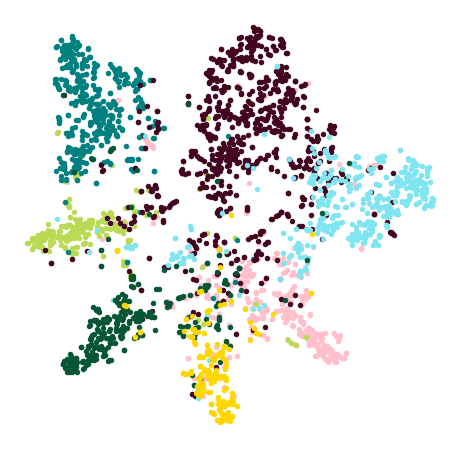

In [36]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model(data.x, data.edge_index, data.edge_weight)
    z = TSNE(n_components=2,init="pca",learning_rate="auto").fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
    '#ffd700'
]
plot_points(colors)

### Compare GCN embedding with Node2vec embedding 
The following scatter plot is the node embedding we obtained from Node2vec in the previous example
![](https://i.imgur.com/7RG5zO6.png)

## Stacking multiple GCN layers to obtain higher order neighbor information



In [37]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True,
                             normalize=True)
        self.conv2 = GCNConv(hidden_channels, hidden_channels, cached=True,
                             normalize=True)
        self.conv3 = GCNConv(hidden_channels, out_channels, cached=True,
                             normalize=True)

    def forward(self, x, edge_index, edge_weight=None):
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv3(x, edge_index, edge_weight)
        return x

In [38]:
dim = 64
model = GCN(dataset.num_features, dim, dataset.num_classes)
model, data = model.to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-4)
print(model)

GCN(
  (conv1): GCNConv(1433, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 7)
)


In [39]:
for epoch in range(400):
    loss = train()
    test_acc = test()
    print(f"Loss:{loss:.4f} Testing accuracy:{test_acc:.4f}")

Loss:1.9458 Testing accuracy:0.2750
Loss:1.9449 Testing accuracy:0.3130
Loss:1.9437 Testing accuracy:0.3730
Loss:1.9421 Testing accuracy:0.4570
Loss:1.9410 Testing accuracy:0.5230
Loss:1.9391 Testing accuracy:0.5900
Loss:1.9387 Testing accuracy:0.6240
Loss:1.9368 Testing accuracy:0.6650
Loss:1.9348 Testing accuracy:0.6920
Loss:1.9330 Testing accuracy:0.7120
Loss:1.9307 Testing accuracy:0.7220
Loss:1.9291 Testing accuracy:0.7330
Loss:1.9268 Testing accuracy:0.7450
Loss:1.9242 Testing accuracy:0.7470
Loss:1.9214 Testing accuracy:0.7560
Loss:1.9193 Testing accuracy:0.7630
Loss:1.9156 Testing accuracy:0.7710
Loss:1.9140 Testing accuracy:0.7830
Loss:1.9092 Testing accuracy:0.7880
Loss:1.9068 Testing accuracy:0.7890
Loss:1.9028 Testing accuracy:0.7960
Loss:1.8988 Testing accuracy:0.7940
Loss:1.8974 Testing accuracy:0.7910
Loss:1.8934 Testing accuracy:0.7960
Loss:1.8869 Testing accuracy:0.7990
Loss:1.8858 Testing accuracy:0.7980
Loss:1.8820 Testing accuracy:0.8010
Loss:1.8751 Testing accuracy

## Applying different GNN backbone layer
The full list of implemented GNN could be found in [here.](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#convolutional-layers)

In [40]:
from torch_geometric.nn import GCNConv,GATConv, GraphSAGE
import torch.nn.functional as F

class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, gnn_type):
        super().__init__()
        if gnn_type == "GCN":
            self.GNN = GCNConv
        elif gnn_type == "SAGE":
            self.GNN = GraphSAGE
        elif gnn_type == "GAT":
            self.GNN = GATConv
        
        self.conv1 = self.GNN(in_channels, hidden_channels)
        self.conv2 = self.GNN(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_weight=None):
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x

In [41]:
dim = 32
gnn_type = "GAT"
model = GNN(dataset.num_features, dim, dataset.num_classes,gnn_type=gnn_type)
model, data = model.to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters())
print(model)

GNN(
  (conv1): GATConv(1433, 32, heads=1)
  (conv2): GATConv(32, 7, heads=1)
)


# Practice: Link prediction with GNN
1. Try different GNN layer
2. Try to optimize the performance by stacking multiple layers
3. Report the best accuracy on testing set and the best model configuration(e.g., how many layers?)

In [42]:
# Let's practice how to use GNN for link prediction
# First we need to load the Cora dataset

import os.path as osp
import torch
from sklearn.metrics import roc_auc_score
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import negative_sampling


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=True),
])
dataset = Planetoid(path, name='Cora', transform=transform)
train_data, val_data, test_data = dataset[0]

In [43]:
print("--------Training data------")
print(train_data)
print("Training edges:")
print(train_data.edge_label_index)
print("Labels")
print(train_data.edge_label)

print()
print("--------Testing data------")
print(test_data)
print("Testing edges:")
print(test_data.edge_label_index)
print("Labels")
print(test_data.edge_label)

--------Training data------
Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[8976], edge_label_index=[2, 8976])
Training edges:
tensor([[1566, 1169,  748,  ..., 1385, 2696,  385],
        [1732, 1737, 2553,  ..., 2266, 1254, 2469]], device='cuda:0')
Labels
tensor([1., 1., 1.,  ..., 0., 0., 0.], device='cuda:0')

--------Testing data------
Data(x=[2708, 1433], edge_index=[2, 9502], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[1054], edge_label_index=[2, 1054])
Testing edges:
tensor([[ 328,  660,  751,  ...,  560, 2410, 1830],
        [1250, 1623, 1204,  ...,  256,  351,  739]], device='cuda:0')
Labels
tensor([1., 1., 1.,  ..., 0., 0., 0.], device='cuda:0')


In [44]:
class MyGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        ############################################################################
        # TODO: Your code here! 
        # create you GNN layer here. 
        # try to use different GNN backbone layer or stacking multiple layer to boost performance
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        
        ############################################################################

    def forward(self, x, edge_index):
        ############################################################################
        # TODO: Your code here! 
        # Apply the forward pass acorrding to your GNN layers
        # you shoud return the embedding of each node (x has shape [num_nodes, dim])
        x = F.relu(self.conv1(x, edge_index))
        
        return self.conv2(x, edge_index)
        ############################################################################
    
    def get_prediction(self,node_embedding, edges):
        # In this function, we have the node embedding and edges as input
        # The output is to generate a scalar for each pair of edge
        # To generate such output, we use the inner product of embeddings of two nodes
        # Input shapes:
        #      node_embedding: (|V|, out_channels)
        #      edges: (2, number of edges)
        embedding_first_node = node_embedding[edges[0]]
        embedding_second_node = node_embedding[edges[1]]
        ############################################################################
        # TODO: Your code here! 
        # implement the element-wise product as edge feature for link prediction
        inner_product = torch.sum(embedding_first_node * embedding_second_node, dim=-1)
        
        ############################################################################
        return inner_product

In [45]:
############################################################################
# TODO: Your code here! 
# initiate your GNN model and select the criterion for link prediction

model = MyGNN(dataset.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()
############################################################################

In [46]:
# Implement the train function
def train():
    model.train()
    optimizer.zero_grad()
    embedding = model(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    
    # Please assign the target for negative edges
    
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)
    
    # make prediction
    prediction = model.get_prediction(embedding, edge_label_index).view(-1)
    
    # optimization
    loss = criterion(prediction, edge_label)
    loss.backward()
    optimizer.step()
    return loss

In [47]:
# Implement the test function
@torch.no_grad()
def test(data):
    model.eval()
    embedding = model(data.x, data.edge_index)
    
    # use the sigmoid function to normalize our prediction into [0,1]
    out = model.get_prediction(embedding, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

In [48]:
best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')


Epoch: 001, Loss: 0.6932, Val: 0.6750, Test: 0.6737
Epoch: 002, Loss: 0.6998, Val: 0.7162, Test: 0.7250
Epoch: 003, Loss: 0.6936, Val: 0.6232, Test: 0.6683
Epoch: 004, Loss: 0.6934, Val: 0.6013, Test: 0.6278
Epoch: 005, Loss: 0.6940, Val: 0.6388, Test: 0.6024
Epoch: 006, Loss: 0.6944, Val: 0.6524, Test: 0.6041
Epoch: 007, Loss: 0.6942, Val: 0.6430, Test: 0.6215
Epoch: 008, Loss: 0.6938, Val: 0.6828, Test: 0.6494
Epoch: 009, Loss: 0.6935, Val: 0.6325, Test: 0.5875
Epoch: 010, Loss: 0.6933, Val: 0.6360, Test: 0.5942
Epoch: 011, Loss: 0.6933, Val: 0.5973, Test: 0.5602
Epoch: 012, Loss: 0.6934, Val: 0.5649, Test: 0.5322
Epoch: 013, Loss: 0.6935, Val: 0.5765, Test: 0.5407
Epoch: 014, Loss: 0.6935, Val: 0.7238, Test: 0.7086
Epoch: 015, Loss: 0.6934, Val: 0.7234, Test: 0.7334
Epoch: 016, Loss: 0.6933, Val: 0.6880, Test: 0.7233
Epoch: 017, Loss: 0.6932, Val: 0.6725, Test: 0.6868
Epoch: 018, Loss: 0.6930, Val: 0.6894, Test: 0.6864
Epoch: 019, Loss: 0.6929, Val: 0.7188, Test: 0.7057
Epoch: 020, 